In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM

device = torch.device("cuda")
dtype = torch.float

In [2]:
data = np.genfromtxt("../data/data_1d.dat")
data = torch.tensor(data, device = device, dtype = dtype)
data = ((data+1)/2)

In [3]:
data.shape

torch.Size([12000, 1000])

In [4]:
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = 200
Nv = data.shape[1]

ep_max = 100

In [5]:
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)   

In [6]:
myRBM.SetVisBias(data.T)
myRBM.fit(data.T, ep_max = ep_max)

IT  0
IT  1
IT  2
IT  3
IT  4
IT  5
IT  6
IT  7
IT  8
IT  9
IT  10
IT  11
IT  12
IT  13
IT  14
IT  15
IT  16
IT  17
IT  18
IT  19
IT  20
IT  21
IT  22
IT  23
IT  24
IT  25
IT  26
IT  27
IT  28
IT  29
IT  30
IT  31
IT  32
IT  33
IT  34
IT  35
IT  36
IT  37
IT  38
IT  39
IT  40
IT  41
IT  42
IT  43
IT  44
IT  45
IT  46
IT  47
IT  48
IT  49
IT  50
IT  51
IT  52
IT  53
IT  54
IT  55
IT  56
IT  57
IT  58
IT  59
IT  60
IT  61
IT  62
IT  63
IT  64
IT  65
IT  66
IT  67
IT  68
IT  69
IT  70
IT  71
IT  72
IT  73
IT  74
IT  75
IT  76
IT  77
IT  78
IT  79
IT  80
IT  81
IT  82
IT  83
IT  84
IT  85
IT  86
IT  87
IT  88
IT  89
IT  90
IT  91
IT  92
IT  93
IT  94
IT  95
IT  96
IT  97
IT  98
IT  99


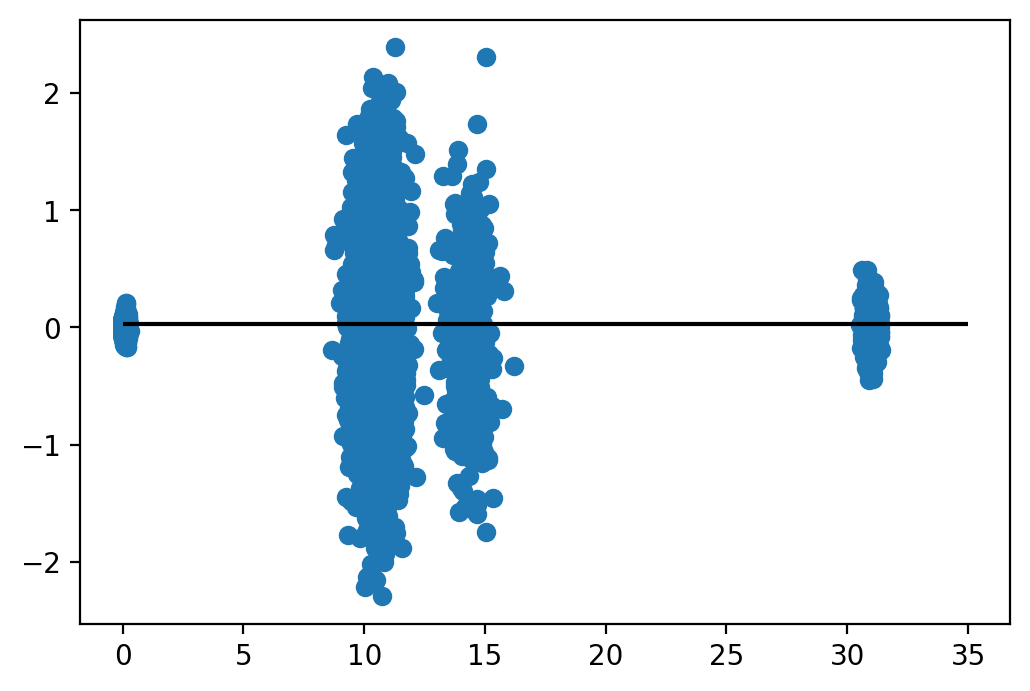

In [7]:
plt.figure(dpi=200)
_, S, V = torch.svd(data)
proj = np.array(torch.mm(data, V).cpu())
#plt.hist(proj[:,0], bins = 100);
plt.scatter(proj[:,0], proj[:,1])
plt.hlines(1/Nv**0.5,0,35,color='black')

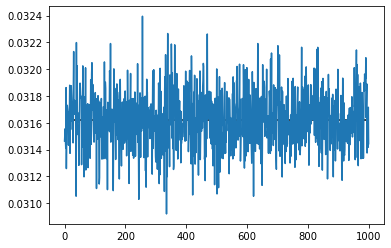

In [8]:
plt.plot(V[:,0].cpu())
plt.hlines(1/Nv**0.5,0,1000,color='black')

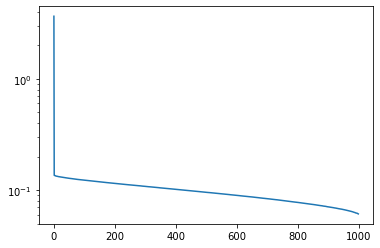

In [9]:
plt.plot(((S/S.sum())*100).cpu())
plt.semilogy()
tmp = S/S.sum()*100



In [10]:
start_points = torch.bernoulli(torch.rand(myRBM.Nv, 1000, device = device))
arrival,_,_,_ = myRBM.Sampling(start_points, it_mcmc = 1000)

In [52]:
def TMCSample(v, w_hat, N, V,it_mcmc=100, ß=1):
    vtab = torch.zeros((v.shape[0],it_mcmc+1))
    vtab[:,0] = v[:,0]
    v_curr = v.cpu()
    V = V.cpu()
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.dot(v_curr[:,0], V)*norm).item()
    
    #print(w_curr)
    
    for t in range(it_mcmc):
        start = time.time()
        h_curr, _ = myRBM.SampleHiddens01(v_curr.cuda())
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)).cpu()
        w_next = w_curr
        
        v_next = torch.clone(v_curr)
        for i in range(v_curr.shape[0]):
            # start_2 = time.time()
            v_next[i] = 1-v_curr[i]
            #print(h_i.shape)
            #print(w_hat)
            #print("bef ",w_next)
            w_next += ((2*v_next[i,0]-1)*V[i]*norm).item()
            #print("aft ",w_next)
            #print(w_curr-w_next)
            #w_next = torch.dot(v_next[:,0], V)/(v.shape[0]**0.5)
            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i]-1)*h_i[i])-N*((w_hat-w_next)**2-(w_hat-w_curr)**2)
            # tmp = torch.exp(ß*((2*v_next[i]-1)*h_i[i])-N*((w_hat-w_next)**2-(w_hat-w_curr)**2))
            #print(tmp.shape)
            # prob = min(1, tmp)
            if ΔE >= 0:      
                #print("t1")
                v_curr[i] = v_next[i]
                w_curr = w_next
            elif (torch.rand(1,1, device = torch.device("cpu"))<torch.exp(ΔE)):
                #print("t1")
                v_curr[i] = v_next[i]
                w_curr = w_next
            else:
                w_next = w_curr
                v_next[i] = 1-v_curr[i]
                            
            #print("upd 1 var exec time = ", start_2-time.time())
        vtab[:,t+1] = v_curr[:,0]
        #print("it_mcmc exec time = ", time.time()-start)
    return v_curr, h_curr, vtab

In [89]:
start = torch.bernoulli(torch.rand(myRBM.Nv, 1, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat = torch.linspace(0,1,steps =100)
y = []
for i in range(len(w_hat)):
    print(i)
    tmpv, tmph, vtab= TMCSample(start, w_hat[i], 10000,V0, it_mcmc = 50)
    y.append(torch.mean(torch.dot(vtab[:,-20].T.cpu(), V0.cpu())))
y = np.array(y)/1000**0.5

0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument mat2 in method wrapper_mm)

In [58]:
proj_gen = torch.mm(arrival.T, V).cpu()/1000**0.5

-0.012568567000104919


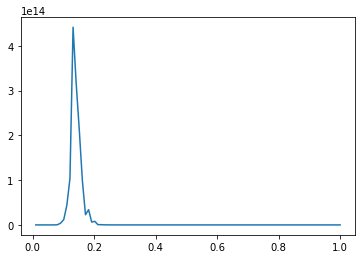

In [85]:
from scipy.integrate import simps
const =1

res=np.zeros(len(w_hat)-1)
print(simps(y-w_hat.numpy(), w_hat.numpy()))
for i in range(1,len(w_hat)):
    res[i-1] = simps(y[:i]-w_hat[:i].numpy(), w_hat[:i].numpy())
res = np.exp(10000*res)*const
plt.plot(w_hat[1:], res)

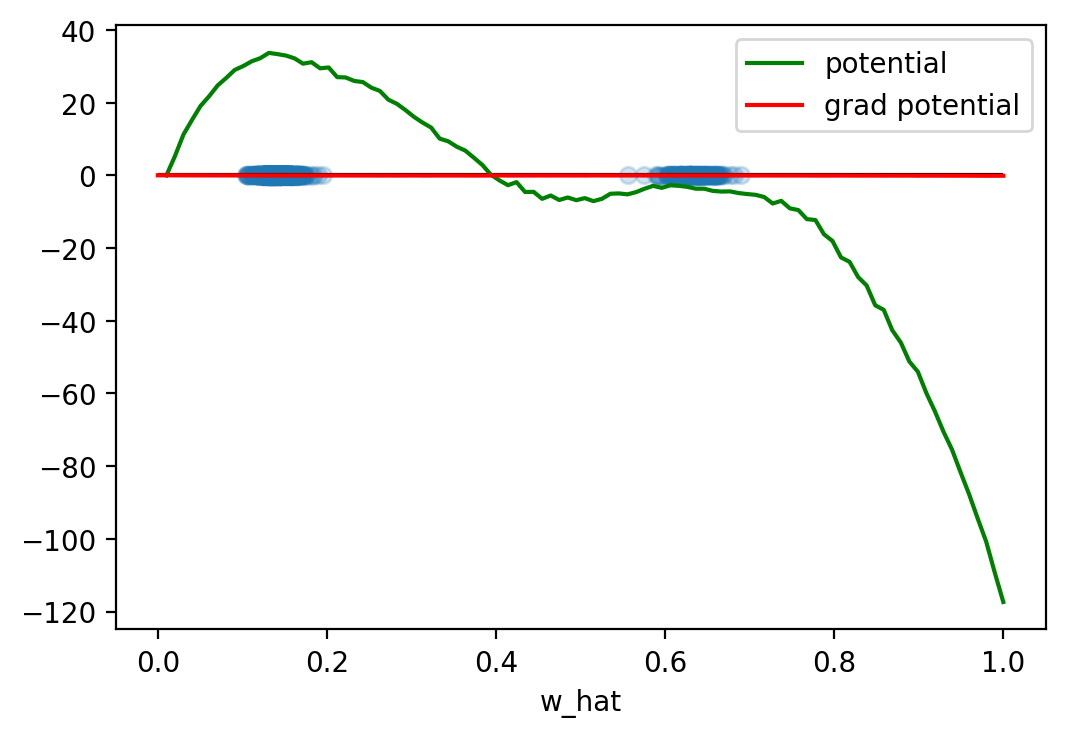

In [78]:
plt.figure(dpi = 200)
plt.plot(w_hat[1:], res, color = "green", label = "potential")
plt.plot(w_hat,y-w_hat.numpy(),color='red', label = "grad potential")
plt.hlines(0,0,1, color = 'black')
plt.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2)
plt.xlabel("w_hat")
plt.legend()

In [50]:
proj_new = torch.mv(vtab.T.cpu(), V0.cpu()).cpu().numpy()/1000**0.5
proj_new

array([0.49809638, 0.9630755 , 0.9131332 , 0.91307175, 0.90493906,
       0.9221063 , 0.92306507, 0.9081382 , 0.91410726, 0.9189958 ,
       0.918056  , 0.92099744, 0.9190262 , 0.916128  , 0.9170947 ,
       0.9230432 , 0.9060984 , 0.9180273 , 0.9219964 , 0.91408443,
       0.9150604 , 0.91495734, 0.9170493 , 0.91511536, 0.9149846 ,
       0.9170747 , 0.91898173, 0.9160702 , 0.91003084, 0.9271073 ,
       0.9150363 ], dtype=float32)

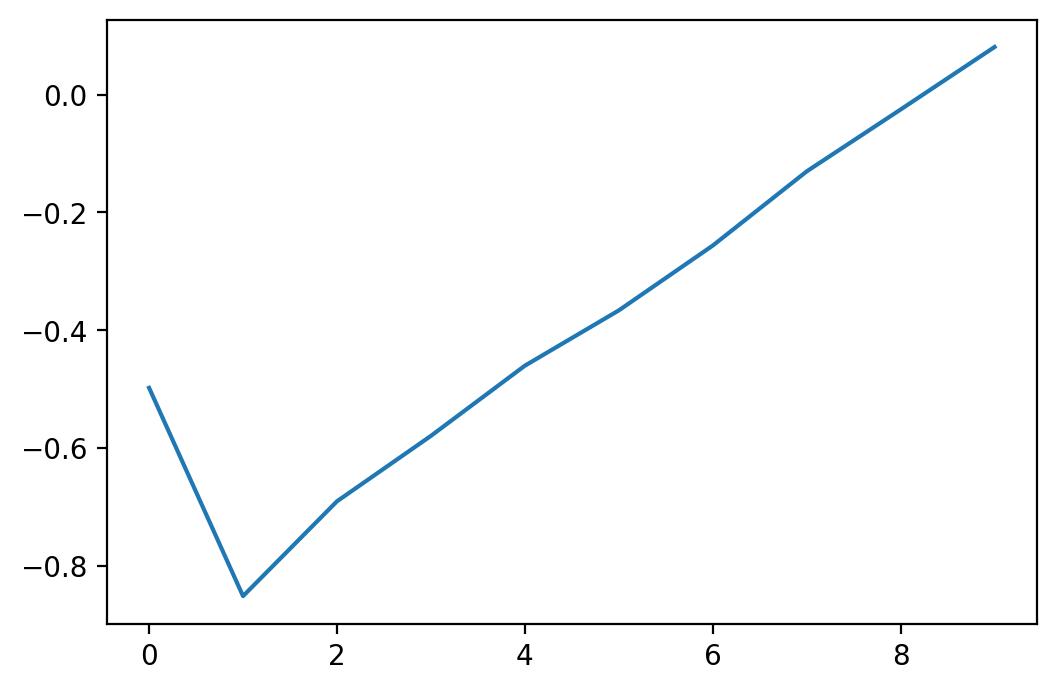

In [51]:
plt.figure(dpi=200)
#plt.hist(proj_new[:,0], bins = 100);
#plt.scatter(proj_new[:,0], proj_new[:, 1])
plt.plot(-proj_new[:10]+w_hat.numpy())

In [16]:
torch.all(torch.tensor([True, False]))

tensor(False)

In [115]:
vtab.shape

torch.Size([1000, 11])

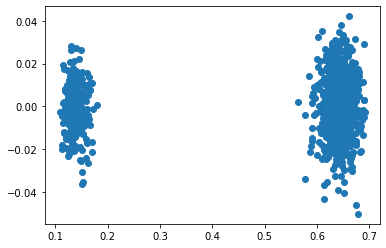

In [391]:
plt.scatter(proj_gen[:,0], proj_gen[:,1])

### MACHINE BIEN ENTRAINEE

In [92]:
W = np.genfromtxt('../data/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../data/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../data/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../data/C1d5c/data_5.dat')
myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().cuda()
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().cuda()
_, S, V = torch.svd(data)


In [93]:
start_points = torch.bernoulli(torch.rand(myRBM.Nv, 1000, device = device))
arrival,_,_,_ = myRBM.Sampling(start_points, it_mcmc = 1000)

In [97]:
start = torch.bernoulli(torch.rand(myRBM.Nv, 1, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat = torch.linspace(0,1,steps =10)
y = []
for i in range(len(w_hat)):
    print(i)
    tmpv, tmph, vtab= TMCSample(start, w_hat[i], 10000,V0, it_mcmc = 30)
    y.append(torch.mean(torch.dot(vtab[:,-20].T.cpu(), V0.cpu())))
y = np.array(y)/myRBM.Nv**0.5

0
1
2
3
4
5
6
7
8
9


In [98]:
proj_gen = torch.mm(arrival.T, V).cpu()/1000**0.5

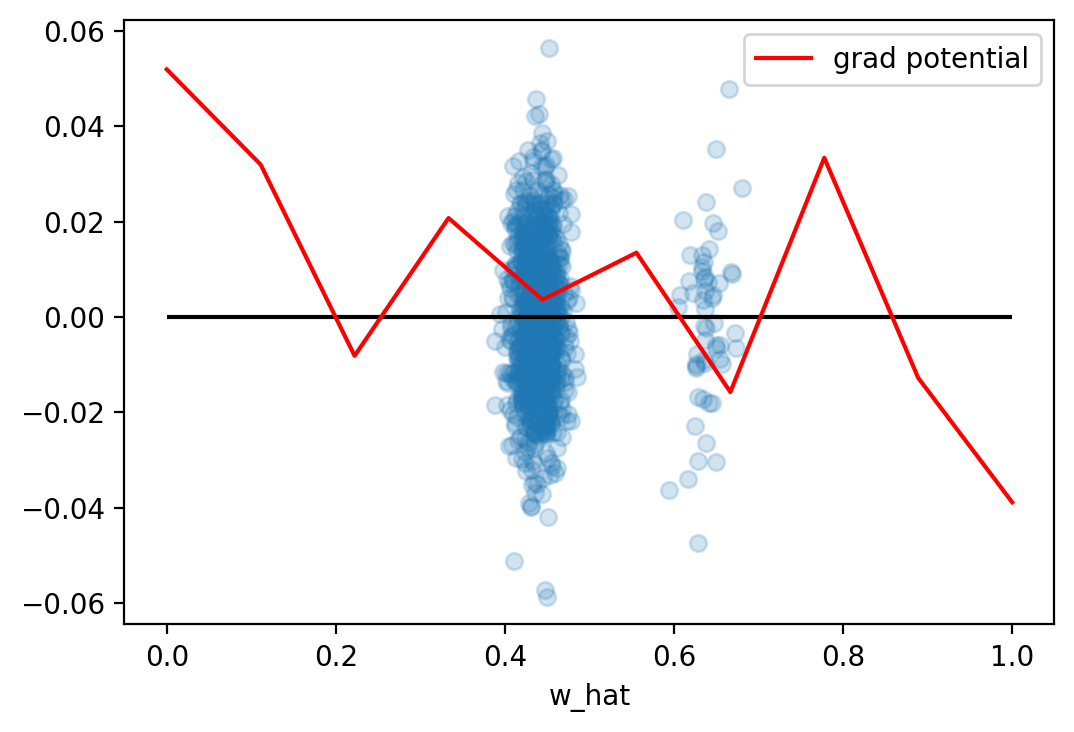

In [101]:
plt.figure(dpi = 200)
#plt.plot(w_hat[1:], res, color = "green", label = "potential")
plt.plot(w_hat,y-w_hat.numpy(),color='red', label = "grad potential")
plt.hlines(0,0,1, color = 'black')
plt.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2)
plt.xlabel("w_hat")
plt.legend()

In [100]:
%debug

> /home/nicolas/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py(399)_plot_args()
    397 
    398         if x.shape[0] != y.shape[0]:
--> 399             raise ValueError(f"x and y must have same first dimension, but "
    400                              f"have shapes {x.shape} and {y.shape}")
    401         if x.ndim > 2 or y.ndim > 2:



ipdb>  u


> /home/nicolas/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py(273)__call__()
    271                 this += args[0],
    272                 args = args[1:]
--> 273             yield from self._plot_args(this, kwargs)
    274 
    275     def get_next_color(self):



ipdb>  u


> /home/nicolas/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py(1743)plot()
   1741         """
   1742         kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)
-> 1743         lines = [*self._get_lines(*args, data=data, **kwargs)]
   1744         for line in lines:
   1745             self.add_line(line)



ipdb>  u


> /home/nicolas/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py(2840)plot()
   2838 @_copy_docstring_and_deprecators(Axes.plot)
   2839 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):
-> 2840     return gca().plot(
   2841         *args, scalex=scalex, scaley=scaley,
   2842         **({"data": data} if data is not None else {}), **kwargs)



ipdb>  u


> <ipython-input-99-35f38c2d1d21>(2)<module>()
      1 plt.figure(dpi = 200)
----> 2 plt.plot(w_hat[1:], res, color = "green", label = "potential")
      3 plt.plot(w_hat,y-w_hat.numpy(),color='red', label = "grad potential")
      4 plt.hlines(0,0,1, color = 'black')
      5 plt.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2)



ipdb>  w_hat.shape


torch.Size([10])


ipdb>  res.shape


(99,)


ipdb>  exot


*** NameError: name 'exot' is not defined


ipdb>  exit
